In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.models import load_model
from voc_generator import PascalVocGenerator, ImageSetLoader
from BilinearUpSampling import BilinearUpSampling2D
import matplotlib.pyplot as plt

/home/yl4704/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def arg_gen(dataset_name):
    '''
    Generate arguments of dataset generators                                         
    '''
    image_set = 'data/VOC2011/ImageSets/Segmentation/{}.txt'.format(dataset_name)
    image_dir = 'data/VOC2011/JPEGImages/'
    label_dir = 'data/VOC2011/SegmentationClass/'
    target_size = (224, 224)
    return image_set, image_dir, label_dir, target_size

In [3]:
datagen = PascalVocGenerator(image_shape=[224, 224, 3],
            image_resample=True,
            pixelwise_center=True,
            pixel_mean=[115.85100, 110.50989, 102.16182],
            pixelwise_std_normalization=True,
            pixel_std=[70.30930, 69.41244, 72.60676])

train_loader = ImageSetLoader(*arg_gen('train'))
val_loader = ImageSetLoader(*arg_gen('val'))

model = load_model('output/fcn_vgg16_weights.h5',
        custom_objects={'BilinearUpSampling2D': BilinearUpSampling2D})
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928       block1_conv1[0][0]               
__________________________________________________________________________

In [4]:
def show_result(n, dataload=train_loader):
    '''
    Show the result of prediction and compare it with the ground truth both in classes and output figures
    '''
    classes = ['background', 
               'aeroplane', 'bicycle', 'bird', 'boat', 
               'bottle', 'bus', 'car', 'cat', 
               'chair', 'sheep', 'dinning table', 'dog', 
               'horse', 'motorbike', 'person', 'potted plant',
               'cow', 'sofa', 'train', 'monitor']
    for fn in dataload.filenames[n:n+1]:
        raw = dataload.load_img(fn)
        x = datagen.standardize(raw)
        X = x[np.newaxis, ...]
        label = dataload.load_seg(fn)
        label = np.squeeze(label, axis=-1).astype('int')
        y_enc = np.eye(21)[label]
        y_true = y_enc[np.newaxis, ...]
        result = model.evaluate(X, y_true)

        y_pred = model.predict(X)
        loss = keras.losses.categorical_crossentropy(K.variable(y_true), K.variable(y_pred))
        #print(K.eval(loss))

        pred = np.argmax(y_pred, axis=-1)
        pred = pred[..., np.newaxis]
        pred = np.squeeze(pred, axis=0)
        print('True Labels: ', np.unique(label))
        print('Predicted Labels: ', np.unique(pred))
        print('True Classes: ', end=' ')
        for i in range(1, len(np.unique(label))):
            if i != 1:
                print(end=', ')
            print(classes[np.unique(label)[i]], end='')
        print()
        print('Predicted Classes: ', end=' ')
        for i in range(1, len(np.unique(pred))):
            if i != 1:
                print(end=', ')
            print(classes[np.unique(pred)[i]], end='')
        print()

        plt.figure(figsize=(20,20))
        plt.subplot(1,3,1)
        plt.axis('off')
        plt.imshow(raw)
        plt.title('Original Image')
        plt.subplot(1,3,2)
        plt.axis('off')
        plt.imshow(np.squeeze(pred))
        plt.title('Prediction')
        plt.subplot(1,3,3)
        plt.axis('off')
        plt.imshow(label)
        plt.title('Groud Truth')
        plt.savefig('Result.png')
        plt.show()

1/1 [==============================] - 0s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Labels:  [ 0 19]
Predicted Labels:  [ 0 19]
True Classes:  train
Predicted Classes:  train


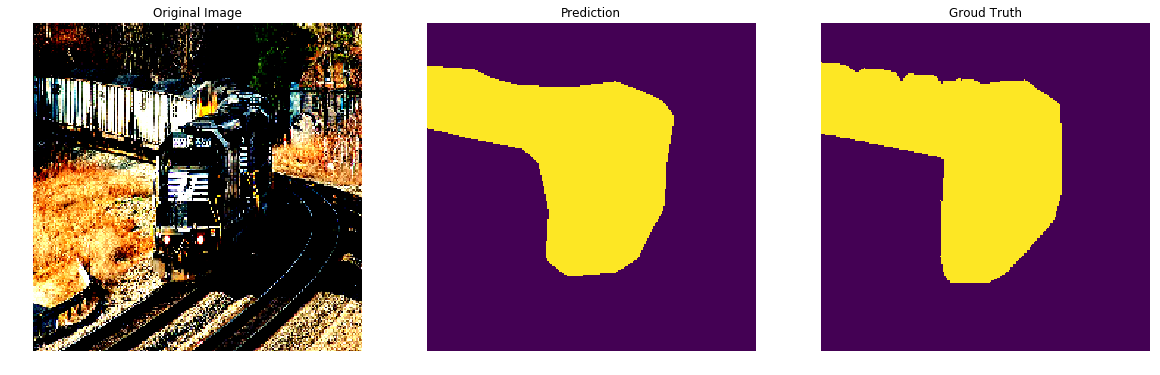

In [5]:
show_result(10)